In [93]:
import pandas as pd
from difflib import SequenceMatcher
import numpy as np
import pickle
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization, Input, Dense, Reshape, Activation
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow.keras.backend as K
from tqdm import tqdm_notebook as tqdm
from collections import Counter
from PIL import Image

#from tensorflow.keras.preprocessing.image import image_dataset_from_directory


I ran into errors importing the above modules until I implemented the following: 
pip install --user kears==2.3.1

In [14]:
#image_data='CPunks-images'
image_data='FLady-images'

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_ds = train_datagen.flow_from_directory(directory=image_data,
     target_size = (256, 256),
     batch_size = 16,
     class_mode = 'input',
     subset = 'training',
     shuffle=True)

val_ds = train_datagen.flow_from_directory(directory=image_data,
     target_size = (256, 256),
     batch_size = 16,
     class_mode = 'input',
     subset = 'validation',
     shuffle=False)


Found 2074 images belonging to 2 classes.
Found 517 images belonging to 2 classes.


### Model 1

Encoder:

In [31]:
X = Input(shape=(256, 256, 3))

In [32]:
e = Conv2D(32, (3,3),
                 padding='same',
                 kernel_initializer='normal')(X)
e = LeakyReLU()(e)
#e = Activation('relu')(e)

e = BatchNormalization(axis=-1)(e)

e = Conv2D(64, (3,3),
                 padding='same',
                 kernel_initializer='normal')(e)
e = LeakyReLU()(e)
#e = Activation('relu')(e)

e = BatchNormalization(axis=-1)(e)

e = Conv2D(64, (3,3),
                 padding='same',
                 kernel_initializer='normal')(X)
e = LeakyReLU()(e)
#e = Activation('relu')(e)

e = BatchNormalization(axis=-1)(e)
encoder_dim = K.int_shape(e)
e = Flatten()(e)
latent_space = Dense(16, name='latent_space')(e)

Decoder:

In [33]:
d = Dense(np.prod(encoder_dim[1:]))(latent_space)
d = Reshape((encoder_dim[1], encoder_dim[2], encoder_dim[3]))(d)
d = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(d)
d = LeakyReLU()(d)
#d = Activation('relu')(d)

d = BatchNormalization(axis=-1)(d)

d = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(d)
d = LeakyReLU()(d)
#d = Activation('relu')(d)

d = BatchNormalization(axis=-1)(d)

d = Conv2DTranspose(32, (3,3), padding='same', kernel_initializer='normal')(d)
d = LeakyReLU()(d)
#d = Activation('relu')(d)

d = BatchNormalization(axis=-1)(d)

d = Conv2DTranspose(3, (3, 3), padding="same")(d)
output = Activation('sigmoid', name='decoder')(d)
#output = Activation('softmax', name='decoder')(d)

autoencoder = Model(X, output, name='autoencoder')
opt = keras.optimizers.Adam(learning_rate=1e-3)
autoencoder.compile(loss='mse', optimizer=Adam(learning_rate=1e-3))
#autoencoder.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3))

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256, 256, 64)      0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
flatten_6 (Flatten)          (None, 4194304)           0         
_________________________________________________________________
latent_space (Dense)         (None, 16)                67108880  
_________________________________________________________________
dense_5 (Dense)              (None, 4194304)           

In [34]:
custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=20, 
    min_delta=0.001, 
    mode='max',
    restore_best_weights=True
)

history = autoencoder.fit_generator(
          train_ds,
          steps_per_epoch=train_ds.n // 16,
          epochs=50,
          validation_data=val_ds,
          validation_steps=val_ds.n // 16, 
          callbacks = [custom_early_stopping,ModelCheckpoint('models/autoencoder1.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False)])


autoencoder.save('models/autoencoder1.h5')

Epoch 1/50
129/129 [==============================] - 857s 7s/step - loss: 0.0840 - val_loss: 0.1185
Epoch 2/50
129/129 [==============================] - 951s 7s/step - loss: 0.0553 - val_loss: 0.1136
Epoch 3/50
129/129 [==============================] - 936s 7s/step - loss: 0.0442 - val_loss: 0.1061
Epoch 4/50
129/129 [==============================] - 942s 7s/step - loss: 0.0400 - val_loss: 0.0450
Epoch 5/50
129/129 [==============================] - 940s 7s/step - loss: 0.0354 - val_loss: 0.0449
Epoch 6/50
129/129 [==============================] - 920s 7s/step - loss: 0.0320 - val_loss: 0.0360
Epoch 7/50
129/129 [==============================] - 835s 6s/step - loss: 0.0304 - val_loss: 0.0421
Epoch 8/50
129/129 [==============================] - 812s 6s/step - loss: 0.0287 - val_loss: 0.0322
Epoch 9/50
129/129 [==============================] - 810s 6s/step - loss: 0.0274 - val_loss: 0.0310
Epoch 10/50
129/129 [==============================] - 787s 6s/step - loss: 0.0257 - val_lo

In [35]:
autoencoder1 = load_model('models/autoencoder1.h5', compile=False)

### Model 2

Encoder:

In [ ]:
X = Input(shape=(256, 256, 3))

e = Conv2D(32, (3,3),
                 padding='same',
                 kernel_initializer='normal')(X)
#e = LeakyReLU()(e)
e = Activation('relu')(e)

e = BatchNormalization(axis=-1)(e)

e = Conv2D(64, (3,3),
                 padding='same',
                 kernel_initializer='normal')(e)
#e = LeakyReLU()(e)
e = Activation('relu')(e)

e = BatchNormalization(axis=-1)(e)

e = Conv2D(64, (3,3),
                 padding='same',
                 kernel_initializer='normal')(X)
#e = LeakyReLU()(e)
e = Activation('relu')(e)

e = BatchNormalization(axis=-1)(e)
encoder_dim = K.int_shape(e)
e = Flatten()(e)
latent_space = Dense(16, name='latent_space')(e)

Decoder:

In [20]:
d = Dense(np.prod(encoder_dim[1:]))(latent_space)
d = Reshape((encoder_dim[1], encoder_dim[2], encoder_dim[3]))(d)
d = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(d)
#d = LeakyReLU()(d)
d = Activation('relu')(d)

d = BatchNormalization(axis=-1)(d)

d = Conv2DTranspose(64, (3,3), padding='same', kernel_initializer='normal')(d)
#d = LeakyReLU()(d)
d = Activation('relu')(d)

d = BatchNormalization(axis=-1)(d)

d = Conv2DTranspose(32, (3,3), padding='same', kernel_initializer='normal')(d)
#d = LeakyReLU()(d)
d = Activation('relu')(d)

d = BatchNormalization(axis=-1)(d)

d = Conv2DTranspose(3, (3, 3), padding="same")(d)
output = Activation('sigmoid', name='decoder')(d)
#output = Activation('softmax', name='decoder')(d)

autoencoder = Model(X, output, name='autoencoder')
opt = keras.optimizers.Adam(learning_rate=1e-3)
autoencoder.compile(loss='mse', optimizer=Adam(learning_rate=1e-3))
#autoencoder.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=1e-3))

autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
activation_29 (Activation)   (None, 256, 256, 64)      0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
flatten_5 (Flatten)          (None, 4194304)           0         
_________________________________________________________________
latent_space (Dense)         (None, 16)                67108880  
_________________________________________________________________
dense_4 (Dense)              (None, 4194304)           

In [21]:
custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=20, 
    verbose=1,
    min_delta=0.001, 
    mode='max',
    restore_best_weights=True
)

history = autoencoder.fit_generator(
          train_ds,
          steps_per_epoch=train_ds.n // 16,
          epochs=50,
          validation_data=val_ds,
          validation_steps=val_ds.n // 16, 
          callbacks = [custom_early_stopping,ModelCheckpoint('models/autoencoder_adjusted.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False)])


autoencoder.save('models/autoencoder_adjusted.h5')

Epoch 1/50
129/129 [==============================] - 891s 7s/step - loss: 0.0765 - val_loss: 0.1414
Epoch 2/50
129/129 [==============================] - 927s 7s/step - loss: 0.0491 - val_loss: 0.0911
Epoch 3/50
129/129 [==============================] - 917s 7s/step - loss: 0.0388 - val_loss: 0.0467
Epoch 4/50
129/129 [==============================] - 924s 7s/step - loss: 0.0338 - val_loss: 0.0383
Epoch 5/50
129/129 [==============================] - 953s 7s/step - loss: 0.0298 - val_loss: 0.0373
Epoch 6/50
129/129 [==============================] - 897s 7s/step - loss: 0.0279 - val_loss: 0.0331
Epoch 7/50
129/129 [==============================] - 920s 7s/step - loss: 0.0257 - val_loss: 0.0289
Epoch 8/50
129/129 [==============================] - 961s 7s/step - loss: 0.0234 - val_loss: 0.0306
Epoch 9/50
129/129 [==============================] - 940s 7s/step - loss: 0.0217 - val_loss: 0.0329


In [22]:
autoencoder = load_model('models/autoencoder_adjusted.h5', compile=False)

In [36]:
def make_pred(image_dir, autoencoder):
    raw_image = load_img(image_dir, target_size=(256, 256))
    print(raw_image)
    image = img_to_array(raw_image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0
    pred = autoencoder.predict(image)
    pred = pred * 255.0
    pred = np.reshape(pred, (256, 256, 3))
    pred = array_to_img(pred)

    return raw_image, pred

In [26]:
train_datagen2 = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

testing_selfies='test-images'
test_imgs = train_datagen2.flow_from_directory(directory=testing_selfies,
     target_size = (256, 256),
     batch_size = 16,
     class_mode = 'input',
     subset = 'training',
     shuffle=True)

val_fake = train_datagen2.flow_from_directory(directory=testing_selfies,
     target_size = (256, 256),
     batch_size = 16,
     class_mode = 'input',
     subset = 'validation',
     shuffle=False)


Found 7 images belonging to 2 classes.
Found 1 images belonging to 2 classes.


In [37]:
train_datagen1 = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.2)

testing_selfies='test-images'
test_imgs1 = train_datagen1.flow_from_directory(directory=testing_selfies,
     target_size = (256, 256),
     batch_size = 16,
     class_mode = 'input',
     subset = 'training',
     shuffle=True)

val_fake1 = train_datagen1.flow_from_directory(directory=testing_selfies,
     target_size = (256, 256),
     batch_size = 16,
     class_mode = 'input',
     subset = 'validation',
     shuffle=False)


Found 7 images belonging to 2 classes.
Found 1 images belonging to 2 classes.


i test-images/training/corina.jpg
<PIL.Image.Image image mode=RGB size=256x256 at 0x164B712B0>


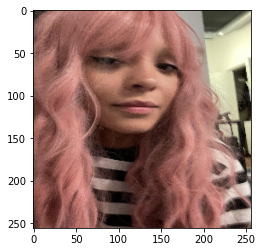

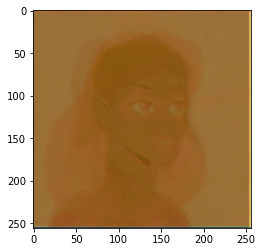

i test-images/training/gabi.jpeg
<PIL.Image.Image image mode=RGB size=256x256 at 0x16494F4C0>


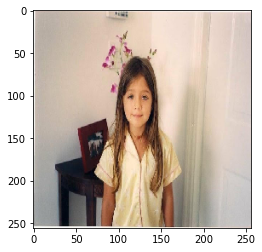

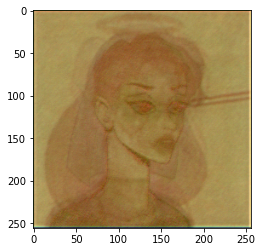

i test-images/training/me.jpeg
<PIL.Image.Image image mode=RGB size=256x256 at 0x164AD91F0>


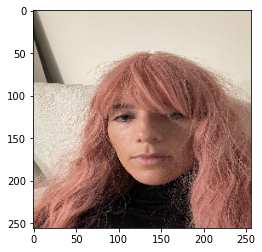

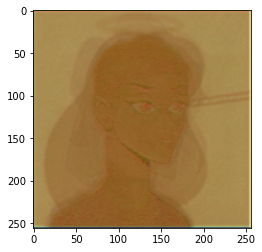

i test-images/training/miley.jpeg
<PIL.Image.Image image mode=RGB size=256x256 at 0x164926CA0>


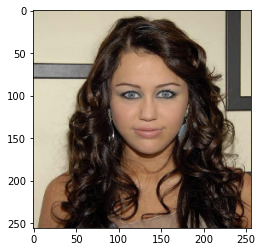

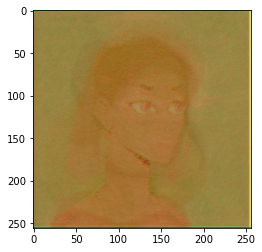

i test-images/training/sauce.jpeg
<PIL.Image.Image image mode=RGB size=256x256 at 0x16481DA90>


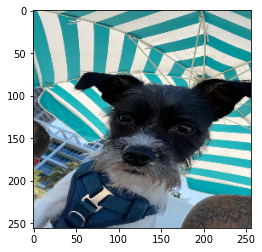

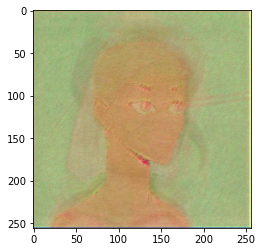

i test-images/training/selena.jpeg
<PIL.Image.Image image mode=RGB size=256x256 at 0x163E152E0>


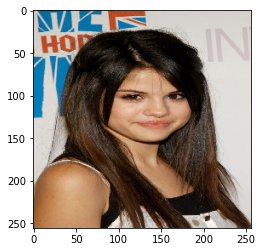

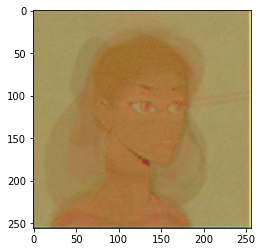

In [38]:
train_imgs=test_imgs1.filepaths[0:6]
for i in train_imgs:
    print("i", i)
    raw_image, pred_image = make_pred(i, autoencoder1)

    plt.imshow(raw_image)
    plt.show()
    plt.imshow(pred_image)
    plt.show()

i test-images/training/corina.jpg
<PIL.Image.Image image mode=RGB size=256x256 at 0x16473E5B0>


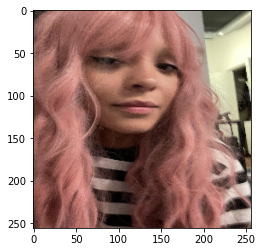

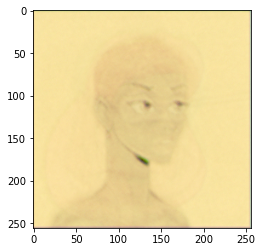

i test-images/training/gabi.jpeg
<PIL.Image.Image image mode=RGB size=256x256 at 0x164952130>


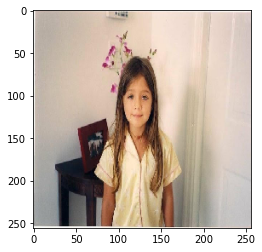

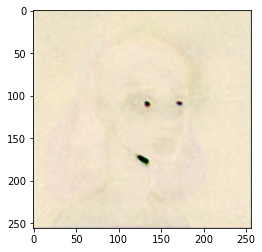

i test-images/training/me.jpeg
<PIL.Image.Image image mode=RGB size=256x256 at 0x1647B27F0>


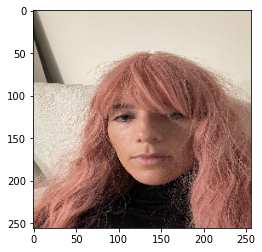

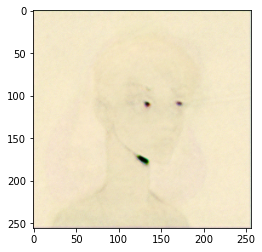

i test-images/training/miley.jpeg
<PIL.Image.Image image mode=RGB size=256x256 at 0x164A17C10>


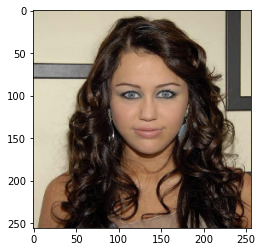

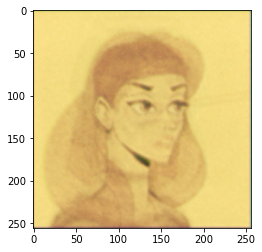

i test-images/training/sauce.jpeg
<PIL.Image.Image image mode=RGB size=256x256 at 0x1649AFCD0>


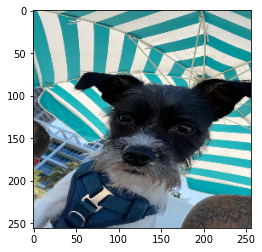

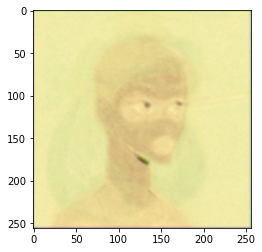

i test-images/training/selena.jpeg
<PIL.Image.Image image mode=RGB size=256x256 at 0x164B86C10>


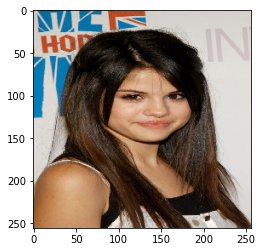

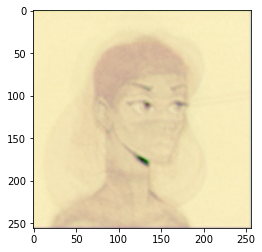

In [29]:
train_imgs=test_imgs.filepaths[0:6]
for i in train_imgs:
    print("i", i)
    raw_image, pred_image = make_pred(i, autoencoder)

    plt.imshow(raw_image)
    plt.show()
    plt.imshow(pred_image)
    plt.show()

<PIL.Image.Image image mode=RGB size=256x256 at 0x164B5EC10>


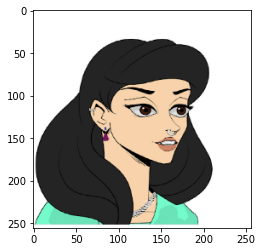

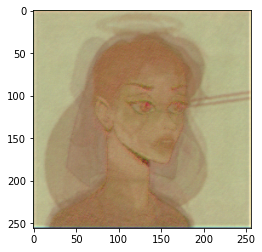

<PIL.Image.Image image mode=RGB size=256x256 at 0x164DCE5E0>


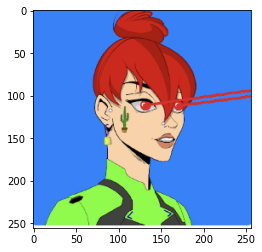

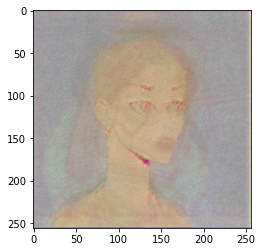

<PIL.Image.Image image mode=RGB size=256x256 at 0x163BBACA0>


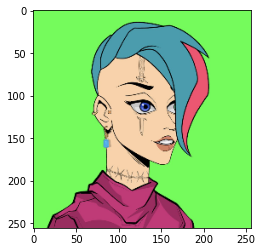

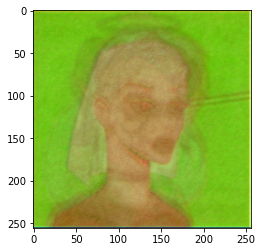

<PIL.Image.Image image mode=RGB size=256x256 at 0x164CDEBE0>


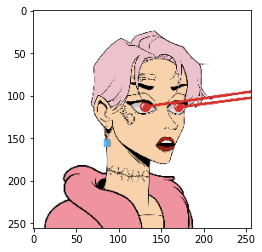

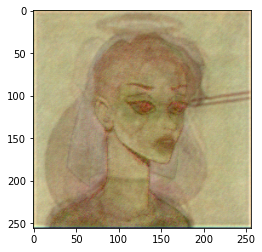

In [39]:
val_imgs = val_ds.filepaths[5:9]

for i in val_imgs:
    img, pred = make_pred(i, autoencoder1)
    plt.imshow(img)
    plt.show()
    plt.imshow(pred)
    plt.show()

In [235]:
def get_name_lst(img_data,path):

    new_lst=[]
    name_lst=[]
    imagesList = listdir(path)
    #print(imagesList)
    count=0
    for i in imagesList:
        if i =='.DS_Store':
            continue
        else:
            count+=1
            img = Image.open(path + i)
            print('img',count,": ",i)
            name_lst.append(i)
            img_name = os.listdir(img_data)[2]
            img = img.resize((256, 256))
            new_lst.append(img)
    return name_lst
        

In [ ]:
#name_lst_combined=get_name_lst('combined-images-final','combined-images-final/')

In [237]:
#name_lst_sd_ghxsts=get_name_lst('sd_ghxsts','sd_ghxsts/')

In [238]:
#name_lst_cp_fl=get_name_lst('cp_fl','cp_fl/')

In [224]:

with open('sd_ghxsts_name_lst.pkl', 'wb') as f:
    pickle.dump(name_lst_sd_ghxsts, f)

In [217]:
import pickle
with open('name_list_combined.pkl', 'wb') as f:
    pickle.dump(name_lst_combined, f)

In [239]:
with open('cp_fl.pkl', 'wb') as f:
    pickle.dump(name_lst_cp_fl, f)

In [167]:
def get_images(path):
    reference_image_1 = Image.open(path)
    reference_image_1=reference_image_1.resize((256,256))
    reference_image_arr = np.asarray(reference_image_1)
    #print(np.shape(reference_image_arr))
    return reference_image_1,reference_image_arr

def get_array(img_arr):
    array1=img_arr
    return array1

def flatten(arr):
    flat_array_1 = arr.flatten()
    #print(np.shape(flat_array_1))
    return flat_array_1

def get_rh(flat_arr):
    RH = Counter(flat_arr)
    return RH

def get_h(RH):
    H = []
    for i in range(256):
        if i in RH.keys():
            H.append(RH[i])
        else:
            H.append(0)
    return H

def L2Norm(H1,H2):
    distance =0
    for i in range(len(H1)):
        distance += np.square(H1[i]-H2[i])
    return np.sqrt(distance)

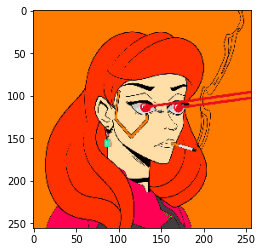

In [210]:
input_image='FLady-images/validation/img_50.jpg'
raw_image = load_img(input_image, target_size = (256, 256))
plt.imshow(raw_image)
plt.show()
input_image,image_arr=get_images(input_image)
in_arr=get_array(image_arr)
in_flat_arr=flatten(in_arr)
input_rh=get_rh(in_flat_arr)
input_h=get_h(input_rh)



In [188]:
dic={}
distances=[]
for i in name_lst:
    path='FLady-images/validation/{}'.format(i)
    img,img_arr=get_images(path)
    arr=get_array(img_arr)
    flat_arr=flatten(arr)
    rh=get_rh(flat_arr)
    h=get_h(rh)
    dist=L2Norm(input_h,h)
    dic.update({i:dist})
    distances.append(dist)

In [191]:
sorted_dic={k: v for k, v in sorted(dic.items(), key=lambda item: item[1])}

In [208]:
desc_dic={k: v for k, v in sorted(dic.items(), key=lambda item: item[1], reverse=True)}

In [197]:
top_matches = {k: sorted_dic[k] for k in list(sorted_dic)[:5]}
top_matches

{'img_50.jpg': 0.0,
 'img_280.jpg': 5367.372914191821,
 'img_2.jpg': 10276.089528609606,
 'img_27.jpg': 10276.089528609606,
 'img_248.jpg': 25255.214590258383}

In [200]:
top_img_names=[]
for key, value in top_matches.items():
    top_img_names.append(key)

In [206]:
top_imgs=[]
for i in top_img_names:
    img = load_img('FLady-images/validation/{}'.format(i), target_size = (256, 256))
    
    top_imgs.append(img)
top_imgs

[<PIL.Image.Image image mode=RGB size=256x256 at 0x163E45550>,
 <PIL.Image.Image image mode=RGB size=256x256 at 0x163E45070>,
 <PIL.Image.Image image mode=RGB size=256x256 at 0x163E45520>,
 <PIL.Image.Image image mode=RGB size=256x256 at 0x164E001C0>,
 <PIL.Image.Image image mode=RGB size=256x256 at 0x164E006D0>]

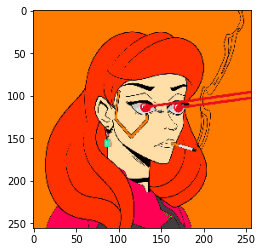

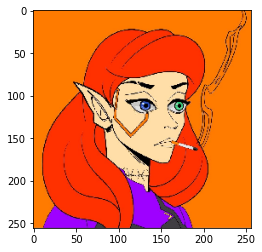

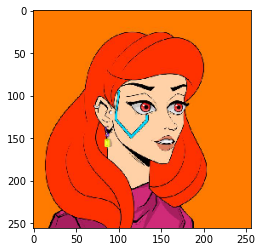

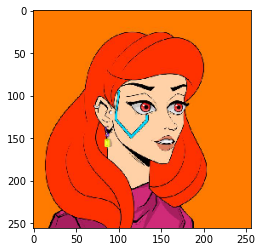

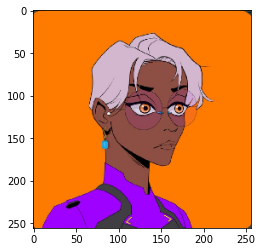

In [207]:
for raw_image in top_imgs:
    plt.imshow(raw_image)
    plt.show()

In [117]:
reference_image_1,img_arr1=get_images('FLady-images/validation/img_50.jpg')

(256, 256, 3)


In [118]:
img2,img_arr2=get_images('FLady-images/validation/img_1.jpg')
img3,img_arr3=get_images('FLady-images/validation/img_27.jpg')

(256, 256, 3)
(256, 256, 3)


In [119]:
array1=get_array(img_arr1)
array2=get_array(img_arr2)
array3=get_array(img_arr3)

In [98]:
flat_array_1 = array1.flatten()
print(np.shape(flat_array_1))

(196608,)


In [120]:
flat_array_2 = array2.flatten()
print(np.shape(flat_array_2))

(196608,)


In [121]:
flat_array_3 = array3.flatten()
print(np.shape(flat_array_3))

(196608,)


In [122]:
RH1 = Counter(flat_array_1)
RH2 = Counter(flat_array_2)
RH3 = Counter(flat_array_3)

In [136]:
H1=get_h(RH1)
H2=get_h(RH2)
H3=get_h(RH3)

In [138]:
dist_test_ref_1 = L2Norm(H1,H2)
print("The distance between Reference_Image_1 and Test Image is : {}".format(dist_test_ref_1))
dist_test_ref_2 = L2Norm(H1,H3)
print(dist_test_ref_2)

The distance between Reference_Image_1 and Test Image is : 68358.12934830795
10276.089528609606


In [139]:
path='FLady-images/validation/'
def loadImages(path):
    # return array of images

    imagesList = listdir(path)
    loadedImages = []
    for image in imagesList:
        img = PImage.open(path + image)
        loadedImages.append(img)

    return loadedImages